<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [3]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   customNet.py    execute.py    resNet.py
AlbTrainTransforms.py  cyclicLR.py     Gradcam.py    rohan_library.py
albumentations.py      DataLoaders.py  LR_Finder.py
all.py		       displayData.py  __pycache__


In [0]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf
import cyclicLR as clr
import customNet

  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [0]:
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [0]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

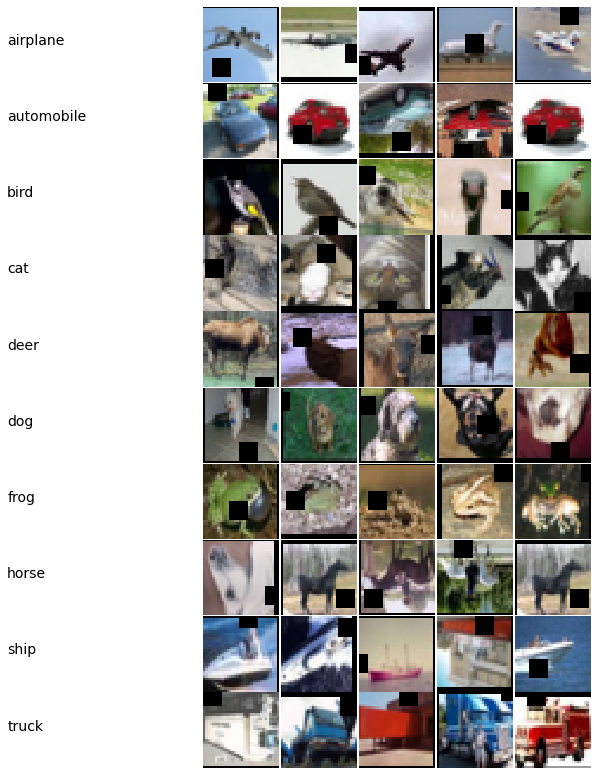

In [10]:
display.class_images(trainLoader)


**CustomNet**

In [11]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = customNet.main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-1

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


**LR Finder**

In [12]:
# criterion = execute.cross_entropy_loss()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


The loss has diverged, Stopping Early!


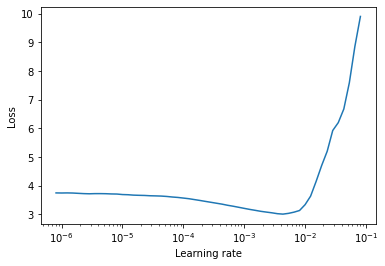

In [13]:
lr_finder.plot()

In [0]:
lr_finder.reset()

**Cyclic Learning Rate Range Test**

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


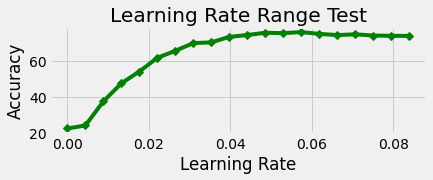

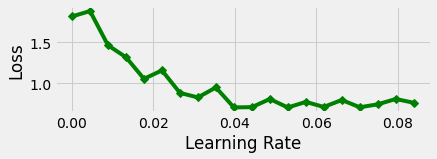

In [15]:
clr.lr_rangetest(device, model, trainLoader, criterion, 0.0001, 0.001, 20)

**Cyclic LR Plot**

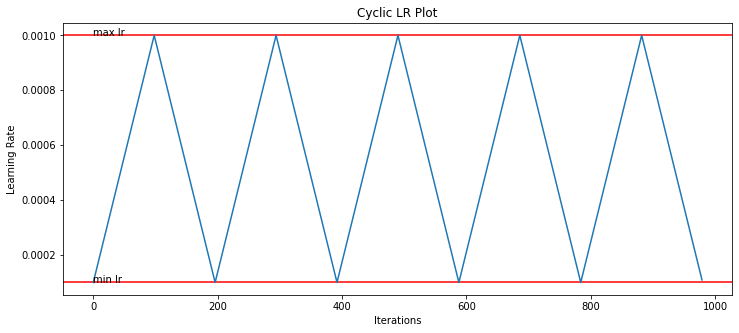

In [17]:
clr1 = clr.CyclicLR(0.001, 0.0001, len(trainLoader), len(trainLoader)*10)
clr1.cyclic_lr(plotGraph=True)

**Modelling**

In [17]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = customNet.main11().to(device)
EPOCHS = 24

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.02, total_steps=2400, epochs = 24, steps_per_epoch=len(trainLoader),
                                                pct_start=5/EPOCHS, anneal_strategy='linear', cycle_momentum=False, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=16)



model1 = execute.Test_Train(model, device, optimizer, scheduler, criterion)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch)#, L1lambda=1e-5)
  scheduler.step()
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1


/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)
Loss=1.5499247312545776 Batch_id=97 Accuracy=35.81: 100%|██████████| 98/98 [00:17<00:00,  5.73it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.4003).  Saving model ...

Test set: Average loss: 1.4003, Accuracy: 4958/10000 (49.58%)

Learning Rate = 0.00497 for EPOCH 2
EPOCH:  2


Loss=1.4959689378738403 Batch_id=97 Accuracy=50.36: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 1.7287, Accuracy: 4529/10000 (45.29%)

Learning Rate = 0.00869 for EPOCH 3
EPOCH:  3


Loss=0.9641804695129395 Batch_id=97 Accuracy=59.57: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.4003 --> 1.2219).  Saving model ...

Test set: Average loss: 1.2219, Accuracy: 6344/10000 (63.44%)

Learning Rate = 0.01241 for EPOCH 4
EPOCH:  4


Loss=0.9170764684677124 Batch_id=97 Accuracy=65.38: 100%|██████████| 98/98 [00:17<00:00,  5.69it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.2219 --> 0.8507).  Saving model ...

Test set: Average loss: 0.8507, Accuracy: 6878/10000 (68.78%)

Learning Rate = 0.01613 for EPOCH 5
EPOCH:  5


Loss=0.875640869140625 Batch_id=97 Accuracy=69.18: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.8507 --> 0.8270).  Saving model ...

Test set: Average loss: 0.8270, Accuracy: 7325/10000 (73.25%)

Learning Rate = 0.01985 for EPOCH 6
EPOCH:  6


Loss=0.7550576329231262 Batch_id=97 Accuracy=73.33: 100%|██████████| 98/98 [00:16<00:00,  5.87it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.8270 --> 0.6811).  Saving model ...

Test set: Average loss: 0.6811, Accuracy: 7749/10000 (77.49%)

Learning Rate = 0.019 for EPOCH 7
EPOCH:  7


Loss=0.5854134559631348 Batch_id=97 Accuracy=76.18: 100%|██████████| 98/98 [00:16<00:00,  5.90it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.7276, Accuracy: 7751/10000 (77.51%)

Learning Rate = 0.01796 for EPOCH 8
EPOCH:  8


Loss=0.7542895674705505 Batch_id=97 Accuracy=78.68: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.6811 --> 0.5942).  Saving model ...

Test set: Average loss: 0.5942, Accuracy: 7937/10000 (79.37%)

Learning Rate = 0.01692 for EPOCH 9
EPOCH:  9


Loss=0.5479499101638794 Batch_id=97 Accuracy=80.90: 100%|██████████| 98/98 [00:16<00:00,  5.80it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5942 --> 0.5180).  Saving model ...

Test set: Average loss: 0.5180, Accuracy: 8082/10000 (80.82%)

Learning Rate = 0.01587 for EPOCH 10
EPOCH:  10


Loss=0.4778777062892914 Batch_id=97 Accuracy=82.42: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6258, Accuracy: 8321/10000 (83.21%)

Learning Rate = 0.01483 for EPOCH 11
EPOCH:  11


Loss=0.45421186089515686 Batch_id=97 Accuracy=83.95: 100%|██████████| 98/98 [00:16<00:00,  5.81it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5180 --> 0.3435).  Saving model ...

Test set: Average loss: 0.3435, Accuracy: 8397/10000 (83.97%)

Learning Rate = 0.01379 for EPOCH 12
EPOCH:  12


Loss=0.43360447883605957 Batch_id=97 Accuracy=85.09: 100%|██████████| 98/98 [00:16<00:00,  5.89it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6028, Accuracy: 8432/10000 (84.32%)

Learning Rate = 0.01275 for EPOCH 13
EPOCH:  13


Loss=0.4007349908351898 Batch_id=97 Accuracy=86.16: 100%|██████████| 98/98 [00:16<00:00,  5.83it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3874, Accuracy: 8480/10000 (84.80%)

Learning Rate = 0.01171 for EPOCH 14
EPOCH:  14


Loss=0.37060093879699707 Batch_id=97 Accuracy=87.06: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4739, Accuracy: 8531/10000 (85.31%)

Learning Rate = 0.01066 for EPOCH 15
EPOCH:  15


Loss=0.32365912199020386 Batch_id=97 Accuracy=88.11: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3656, Accuracy: 8630/10000 (86.30%)

Learning Rate = 0.00962 for EPOCH 16
EPOCH:  16


Loss=0.3106916844844818 Batch_id=97 Accuracy=88.72: 100%|██████████| 98/98 [00:16<00:00,  5.77it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.3435 --> 0.3382).  Saving model ...

Test set: Average loss: 0.3382, Accuracy: 8651/10000 (86.51%)

Learning Rate = 0.00858 for EPOCH 17
EPOCH:  17


Loss=0.3128865957260132 Batch_id=97 Accuracy=89.83: 100%|██████████| 98/98 [00:16<00:00,  5.78it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4276, Accuracy: 8692/10000 (86.92%)

Learning Rate = 0.00754 for EPOCH 18
EPOCH:  18


Loss=0.29092898964881897 Batch_id=97 Accuracy=90.49: 100%|██████████| 98/98 [00:16<00:00,  5.92it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4203, Accuracy: 8733/10000 (87.33%)

Learning Rate = 0.00649 for EPOCH 19
EPOCH:  19


Loss=0.2182057499885559 Batch_id=97 Accuracy=91.26: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3788, Accuracy: 8788/10000 (87.88%)

Learning Rate = 0.00545 for EPOCH 20
EPOCH:  20


Loss=0.24500474333763123 Batch_id=97 Accuracy=91.95: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.4309, Accuracy: 8741/10000 (87.41%)

Learning Rate = 0.00441 for EPOCH 21
EPOCH:  21


Loss=0.2469017654657364 Batch_id=97 Accuracy=92.53: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.3382 --> 0.2863).  Saving model ...

Test set: Average loss: 0.2863, Accuracy: 8835/10000 (88.35%)

Learning Rate = 0.00337 for EPOCH 22
EPOCH:  22


Loss=0.21806581318378448 Batch_id=97 Accuracy=92.90: 100%|██████████| 98/98 [00:16<00:00,  5.88it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3768, Accuracy: 8857/10000 (88.57%)

Learning Rate = 0.00233 for EPOCH 23
EPOCH:  23


Loss=0.17675769329071045 Batch_id=97 Accuracy=93.65: 100%|██████████| 98/98 [00:16<00:00,  5.91it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3546, Accuracy: 8859/10000 (88.59%)

Learning Rate = 0.00128 for EPOCH 24
EPOCH:  24


Loss=0.15862351655960083 Batch_id=97 Accuracy=93.95: 100%|██████████| 98/98 [00:16<00:00,  5.95it/s]



Test set: Average loss: 0.4035, Accuracy: 8875/10000 (88.75%)

Learning Rate = 0.00024 for EPOCH 25


**Plot Train & Test Curves**

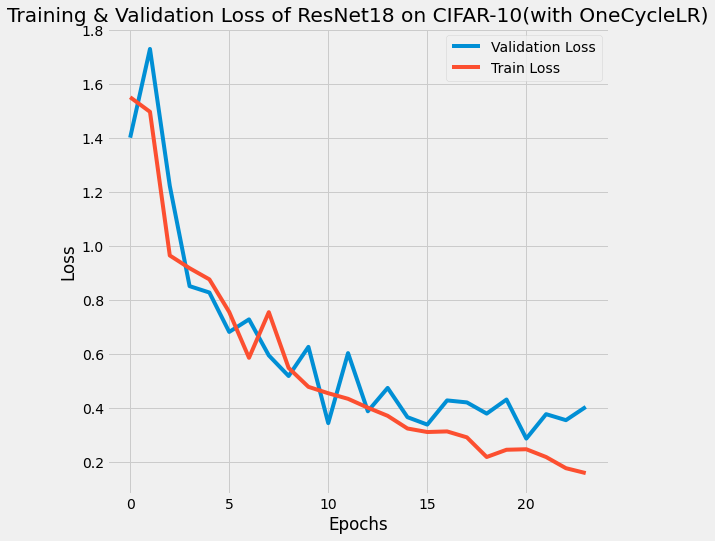

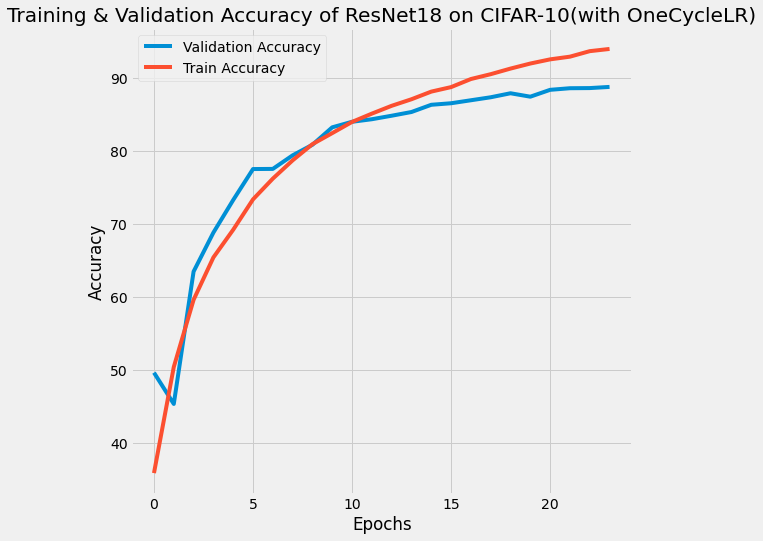

In [18]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of ResNet18 on CIFAR-10(with OneCycleLR)', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of ResNet18 on CIFAR-10(with OneCycleLR)')


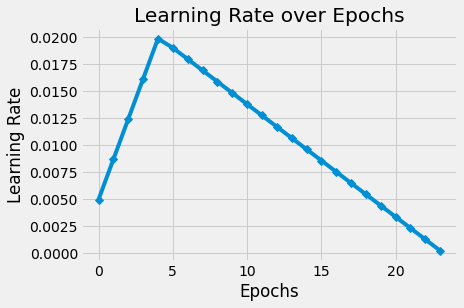

In [25]:
with plt.style.context('fivethirtyeight'):
  plt.plot(learningRates, '-D')
  plt.xlabel('Epochs')
  plt.ylabel('Learning Rate')
  plt.title('Learning Rate over Epochs')

**Misclassified Images**

<Figure size 936x936 with 0 Axes>

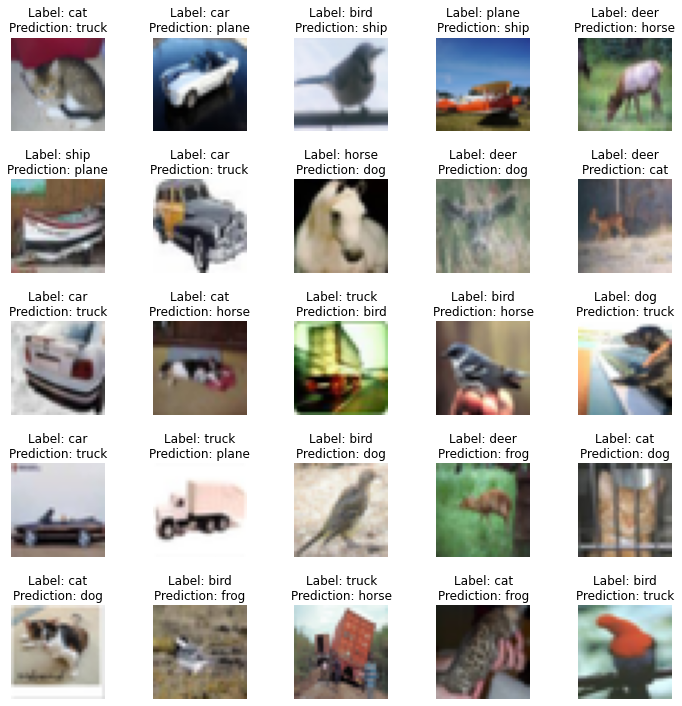

In [26]:
display.misclassified_ones(model, testLoader, incorrectSamples,'MisclassfiedOnes.png')

#GradCam Implementation

**GradCam Input Data**

In [0]:
images = [x['image'] for x in incorrectSamples[10:35]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[10:35]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[10:35]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


**GradCam Core** 

IMPLEMENTING GRADCAM FOR SET1[...]
torch.Size([25, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


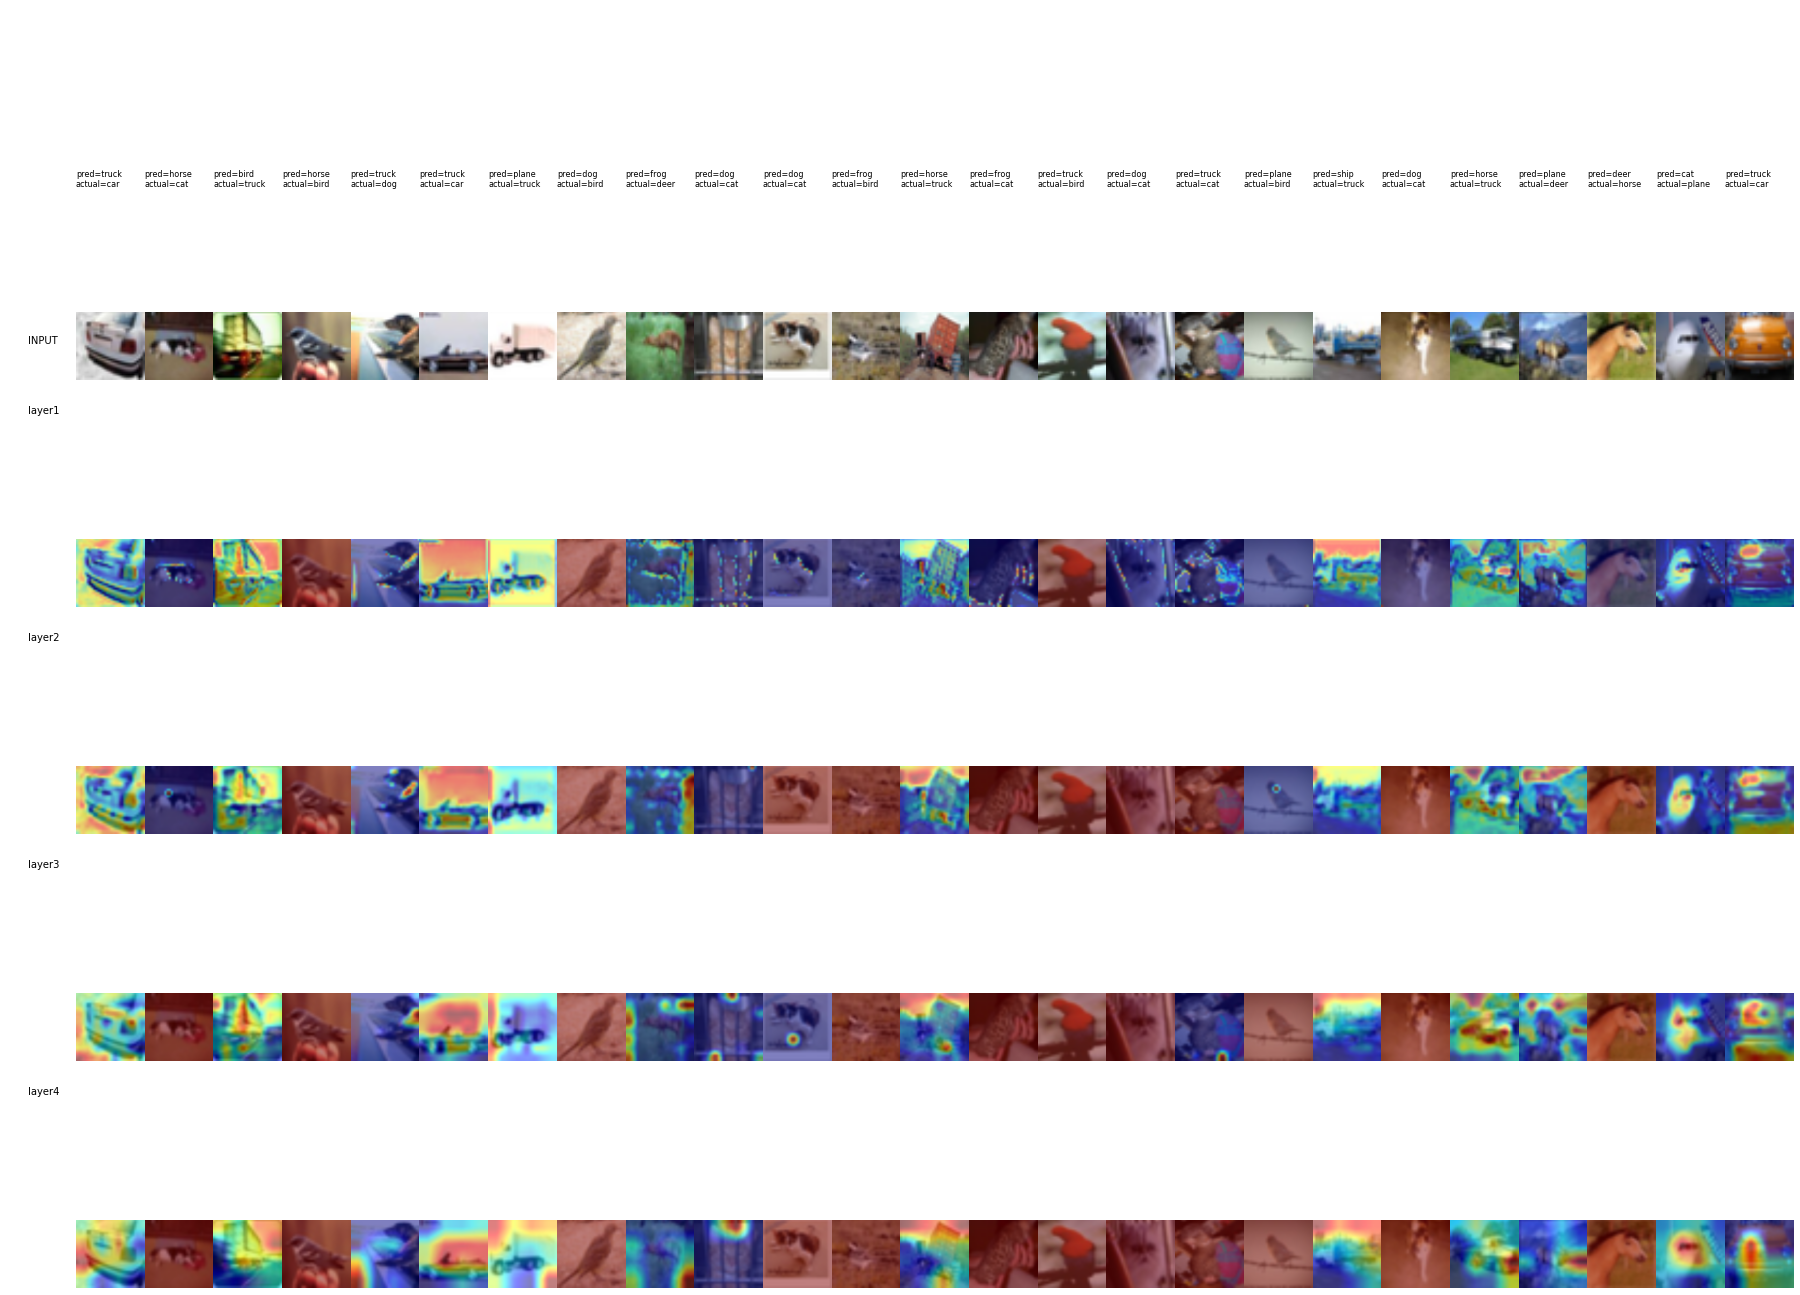

In [28]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM FOR SET1[...]')
gradcam_output, probs, predicted_classes = gdc.GRADCAM(images, device, target_classes, model, target_layers) 
gdc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
